In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [2]:
print(f'pandas version is: {pd.__version__}')
print(f'numpy version is: {np.__version__}')
print(f'matplotlib version is: {matplotlib.__version__}')
print(f'sklearn version is: {sklearn.__version__}')
print(f'xgboost version is: {xgb.__version__}')

pandas version is: 2.1.4
numpy version is: 1.26.4
matplotlib version is: 3.8.0
sklearn version is: 1.4.1.post1
xgboost version is: 2.0.3


源代码版本

```text
pandas version is: 1.1.2
numpy version is: 1.18.5
matplotlib version is: 3.2.2
sklearn version is: 0.22.2.post1
xgboost version is: 0.90
```

In [3]:
#all helper functions used

def drop_columns(data, *args):
    '''
    function used to drop columns.
    args:: 
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''
    
    # columns = []
    # for _ in args:
    #     columns.append(_)
        
    columns = list(args)
        
    data = data.drop(columns, axis=1)
        
    return data

def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])
        
    return data
 
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl

# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''
    
    A = np.load('penalty_matrix.npy')
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]


In [4]:
# 修改工作路径
PWD = '../../data/'

In [14]:
#importing penaltry matrix used for evaluation and train and test files
A = np.load(f'{PWD}penalty_matrix.npy')

train = pd.read_csv(f'{PWD}train.csv', sep=';')

test = pd.read_csv(f'{PWD}test.csv', sep=';')

## preprocess 方法

`preprocess`方法是`Model`类中的一个关键方法，它负责准备训练和测试数据集以进行模型训练和预测。以下是`preprocess`方法的分析：



###  方法定义
```python
def preprocess(self, train, test):
    '''
    准备数据集以进行训练和预测
    接受训练和测试数据框作为参数

    返回准备好的训练和测试数据集以及岩石标签和数字，这些是准备提交文件所必需的
    '''
    # ... (省略了方法体)
```

###  方法作用
-  合并训练和测试数据集，以便于统一处理。
-  将岩石标签映射到序数值，以便于模型处理。
-  实现Bestagini的增强过程，这可能是一种特殊的数据增强技术。
-  删除不需要的列。
-  对特定的特征进行标签编码，以提高模型性能。
-  将合并后的数据集分割为训练和测试数据集。
-  对数据进行进一步的预处理，包括填充缺失值和其他可能的转换。
-  对训练数据进行增强，以增加模型的泛化能力。
-  返回预处理后的训练和测试数据集，以及岩石标签和数字。

###  方法步骤
1. **合并训练和测试数据集**：
   ```python
   ntrain = train.shape[0]
   ntest = test.shape[0]
   target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
   df = pd.concat((train, test)).reset_index(drop=True)
   ```
   这一步将训练数据集和测试数据集合并，以便于统一处理。

2. **映射岩石标签**：
   ```python
   lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
   lithology_numbers = {30000:  0,  65030:  1,  65000:  2,  80000:  3,  74000:  4,  70000:  5,  70032:  6,  88000:  7,  86000:  8,  99000:  9,  90000:  10,  93000:  11}
   lithology1 = lithology.map(lithology_numbers)
   ```
   这一步将岩石标签映射到序数值，以便于模型处理。

3. **实现增强过程**：
   ```python
   train_well = train.WELL.values
   train_depth = train.DEPTH_MD.values
   test_well = test.WELL.values
   test_depth = test.DEPTH_MD.values
   ```
   这一步可能是实现Bestagini的增强过程，这是一种特殊的数据增强技术，用于增加模型的泛化能力。

4. **删除不需要的列**：
   ```python
   cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
   df = drop_columns(df, *cols)
   ```
   这一步删除了不需要的列，以减少模型的复杂性和计算量。

5. **标签编码**：
   ```python
   df['GROUP_encoded'] = df['GROUP'].astype('category')
   df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes  
   df['FORMATION_encoded'] = df['FORMATION'].astype('category')
   df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
   df['WELL_encoded'] = df['WELL'].astype('category')
   df['WELL_encoded'] = df['WELL_encoded'].cat.codes
   ```
   这一步对特定的特征进行标签编码，以提高模型性能。

6. **分割数据集**：
   ```python
   df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
   df = df.fillna(-999)
   df = process(df)
   data = df.copy()
   train2 = data[:ntrain].copy()
   test2 = data[ntrain:(ntest+ntrain)].copy()
   ```
   这一步将合并后的数据集分割为训练和测试数据集。

7. **数据预处理**：
   ```python
   train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
   test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
   test2 = test2.reset_index(drop=True)
   ```
   这一步对数据进行进一步的预处理，包括填充缺失值和其他可能的转换。

8. **数据增强**：
   ```python
   traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
   testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
   ```
   这一步对训练数据进行增强，以增加模型的泛化能力。

9. **返回结果**：
   ```python
   return traindata1, testdata1, lithology1, lithology_numbers
   ```
   最后，返回预处理后的训练和测试数据集，以及岩石标签和数字。

###  方法输出
- `traindata1`：预处理后的训练数据集。
- `testdata1`：预处理后的测试数据集。
- `lithology1`：岩石标签的序数值。
- `lithology_numbers`：岩石标签和数字的映射字典。

###  方法注意事项
- `drop_columns`和`process`函数在提供的代码片段中没有定义，但它们可能是用于数据预处理的实用函数。
- `augment_features`函数也在提供的代码片段中没有定义，但它可能是用于实现数据增强的函数。


总的来说，`preprocess`方法的作用是将原始数据集转换为模型可以接受的格式，包括数据清洗、特征工程、标签编码和数据增强等步骤。这些步骤有助于提高模型的性能和泛化能力，使得模型能够更好地适应新的数据。

## `fit`方法

在`Model`类中，`fit`方法是用于训练模型的关键部分。虽然在提供的代码片段中没有明确定义`fit`方法，但根据类的描述和通常的机器学习模式，我们可以推测`fit`方法的作用。以下是`fit`方法的预期功能：



### `fit`方法的预期功能
- **训练模型**：使用预处理后的训练数据集来训练机器学习模型。这通常涉及到选择一个模型架构，设置训练参数，并使用训练数据集来调整模型的参数。
- **交叉验证**：使用交叉验证来评估模型的性能。这通常涉及到将数据集分割成多个折叠，然后在每个折叠上训练模型并评估其性能。
- **早停**：在训练过程中使用早停策略来防止过拟合。如果模型在验证集上的性能不再提高，训练将提前停止。
- **预测**：在训练过程中或之后，使用模型对测试数据集进行预测。
- **评估**：计算模型在测试数据集上的性能指标，如准确率、精确度、召回率和F1分数。
- **可视化**：如果`plot`参数为`True`，可能会生成一些可视化结果，如特征重要性图表或训练过程的图表。

### `fit`方法的预期实现
基于`Model`类的描述和通常的机器学习流程，`fit`方法的实现可能包括以下步骤：

1. **预处理数据**：调用`preprocess`方法来准备训练和测试数据集。

2. **设置模型**：选择一个模型架构，例如XGBoost的`XGBClassifier`，并设置训练参数。

3. **交叉验证**：使用`StratifiedKFold`进行交叉验证，以确保每个折叠都有相同比例的目标类别样本。

4. **训练模型**：在每个折叠上训练模型，并使用早停策略来防止过拟合。

5. **预测**：在训练过程中或之后，使用模型对测试数据集进行预测。

6. **评估**：计算模型在测试数据集上的性能指标。

7. **可视化**：如果`plot`参数为`True`，生成可视化结果。

###  示例代码
尽管`fit`方法在提供的代码片段中没有定义，但根据上述预期功能，我们可以编写一个示例实现：

```python
def fit(self, plot=True):
    # 预处理数据
    traindata, testdata, lithology, lithology_numbers = self.preprocess(self.train, self.test)

    #  设置模型
    model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                      objective='multi:softprob', learning_rate=0.1, random_state=0,
                      subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                      eval_metric='mlogloss', verbose=2020, reg_lambda=1500)

    #  交叉验证
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in kf.split(traindata, lithology):
        X_train, X_test = traindata[train_index], traindata[test_index]
        Y_train, Y_test = lithology[train_index], lithology[test_index]
        # 训练模型
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        # 预测
        predictions = model.predict(X_test)
        # 评估
        if plot:
            #  生成可视化结果
            plot_evaluation(predictions, Y_test)
    #  返回模型和预测结果
    return model, predictions
```

在这个示例中，我们假设`plot_evaluation`是一个用于可视化模型性能的函数，它接受预测结果和真实标签作为参数。实际的`fit`方法可能会有更多的细节和优化，例如模型选择、超参数调整和性能评估等。


###  注意事项
- `XGBClassifier`是XGBoost库中的一个类，用于创建一个用于分类任务的梯度提升模型。
- `StratifiedKFold`是`sklearn.model_selection`模块中的一个类，用于以分层方式将数据分割成训练/测试集。
- `early_stopping_rounds`参数用于设置早停策略，当连续`early_stopping_rounds`轮训练后，如果验证集上的性能没有提高，则停止训练。
- `eval_set`参数用于在训练过程中评估模型性能。
- `verbose`参数用于控制训练过程中的输出级别。


总的来说，`fit`方法的目标是训练一个模型，使其能够在测试数据集上做出准确的预测。这通常涉及到数据预处理、模型选择、训练、评估和可能的可视化步骤。

## `plot_feat_imp`方法

`plot_feat_imp`方法是用于绘制特征重要性图表的辅助方法。以下是`plot_feat_imp`方法的分析：

分析`plot_feat_imp`方法的实际代码：

```python
def plot_feat_imp(self, model):
    """
    
    """
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
```

###  方法定义
`plot_feat_imp`方法是`Model`类的一个成员方法，用于可视化模型中各个特征的重要性。它接受一个模型作为参数，该模型应该是一个已经训练好的机器学习模型，具有`feature_importances_`属性，该属性包含了模型中各个特征的重要性得分。

###  方法作用
- **计算特征重要性**：从模型中提取特征重要性得分，并将其转换为一个pandas Series对象。
- **排序特征重要性**：对特征重要性得分进行降序排序，以便于可视化时可以清楚地看到最重要的特征。
- **绘制特征重要性图表**：使用matplotlib库绘制一个条形图，显示各个特征的重要性得分。

###  方法步骤
1. **提取特征重要性**：
   ```python
   feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
   ```
   这一步从模型中提取特征重要性得分，并将其转换为一个pandas Series对象。`model.feature_importances_`是一个数组，包含了模型中各个特征的重要性得分。

2. **设置图表大小**：
   ```python
   plt.figure(figsize=(12,8))
   ```
   这一步设置了图表的大小，使其更适合显示特征重要性的条形图。

3. **绘制条形图**：
   ```python
   feat_imp.plot(kind='bar', title='Feature Importances')
   ```
   这一步使用matplotlib库的`plot`方法绘制了一个条形图，显示了各个特征的重要性得分。图表的标题是“Feature Importances”。

4. **设置y轴标签**：
   ```python
   plt.ylabel('Feature Importance Score')
   ```
   这一步设置了y轴的标签为“Feature Importance Score”，表示特征重要性得分。

###  方法输出
- **特征重要性图表**：一个条形图，显示了各个特征的重要性得分。

###  方法注意事项
-  这个方法假设模型已经训练好，并且具有`feature_importances_`属性。这通常适用于树模型（如决策树、随机森林、梯度提升等），这些模型在训练过程中会计算特征的重要性。
-  如果模型不支持特征重要性得分，或者没有训练好，这个方法将无法正常工作。
-  图表的标题和y轴标签可以根据需要进行修改，以提供更多的上下文信息。


###  示例代码
这个方法的实现是正确的，它将绘制出一个条形图，显示模型中各个特征的重要性得分。这对于理解模型的决策过程非常有用，因为它可以帮助我们确定哪些特征对模型的预测结果影响最大。


###  注意事项
-  这个方法没有返回值，它只是绘制了一个图表。如果需要在其他地方使用特征重要性得分，可能需要修改方法以返回这些得分。
-  如果模型不支持特征重要性得分，或者没有训练好，这个方法将无法正常工作。
-  图表的标题和y轴标签可以根据需要进行修改，以提供更多的上下文信息。


总的来说，`plot_feat_imp`方法的目标是提供一个直观的方式来查看模型中各个特征的重要性，这对于模型解释和特征选择非常有用。

### 提交训练相关的方法

在Model类中，make_submission_file方法的作用是训练模型，进行预测，并创建一个提交文件。这个方法通常用于机器学习竞赛，其中参赛者需要将他们的预测结果提交到一个特定的平台上，以便于评估他们的模型性能。以下是make_submission_file方法的分析：

## make_submission_file`方法

在`Model`类中，`make_submission_file`方法的作用是训练模型，进行预测，并创建一个提交文件。这个方法通常用于机器学习竞赛，其中参赛者需要将他们的预测结果提交到一个特定的平台上，以便于评估他们的模型性能。以下是`make_submission_file`方法的分析：



###  方法定义
```python
def make_submission_file(self, filename):
    '''
    method to train model, make prediction and create submission file
    args::
    filename: str, the name of the submission file
    '''
    # ... (省略了方法体)
```

###  方法作用
- **训练模型**：使用预处理后的训练数据集来训练机器学习模型。
- **预测**：在训练过程中或之后，使用模型对测试数据集进行预测。
- **创建提交文件**：基于模型的预测结果，创建一个提交文件，以便于在竞赛平台上提交结果。

###  方法步骤
1. **训练模型**：调用`fit`方法来训练模型。这通常涉及到选择一个模型架构，设置训练参数，并使用训练数据集来调整模型的参数。

2. **预测**：使用训练后的模型对测试数据集进行预测。

3. **创建提交文件**：基于模型的预测结果，创建一个提交文件。这通常涉及到将预测结果格式化为所需的提交格式，并将其保存到文件中。

###  方法输出
- **提交文件**：一个文件，包含了模型的预测结果，以便于在竞赛平台上提交。

###  方法注意事项
- `filename`参数是提交文件的名称。这个文件应该包含了模型的预测结果，以便于在竞赛平台上提交。
- 具体的预测和提交文件创建过程没有在提供的代码片段中定义，但通常会涉及到模型的预测方法和数据处理步骤。

###  示例代码
尽管`make_submission_file`方法在提供的代码片段中没有定义，但根据上述预期功能，我们可以编写一个示例实现：

```python
def make_submission_file(self, filename):
    # 训练模型
    model, predictions = self.fit()
    
    #   创建提交文件
    submission = pd.DataFrame({
        'id': test_data['id'],
        'lithology': predictions
    })
    submission.to_csv(filename, index=False)
```

在这个示例中，我们假设`fit`方法返回一个模型和预测结果，`test_data`是测试数据集，包含了每个样本的唯一标识符`id`。我们创建一个包含`id`和预测结果的提交文件，并保存到指定的文件名中。


###  注意事项
-   实际的`make_submission_file`方法可能会有更多的细节和优化，例如特征重要性的可视化、模型性能的评估等。
-   提交文件的格式可能会根据竞赛平台的要求有所不同，需要根据具体情况进行调整。


总的来说，`make_submission_file`方法的目标是训练一个模型，使用模型对测试数据集进行预测，并创建一个提交文件，以便于在竞赛平台上提交结果。这通常涉及到数据预处理、模型训练、预测和提交文件创建等步骤。

## Model

In [13]:
class Model():
  
    '''
    
    lithology 岩石分类 prediction 预测
    该类用于基于测井数据构建岩石分类的机器学习模型。类方法包括数据预处理、模型训练、预测和生成提交文件等功能。

    属性:
      train (DataFrame): 包含特征和目标的训练数据集。
      test (DataFrame): 仅包含特征的测试数据集。

    方法:
      preprocess(train, test): 准备训练和预测数据集。
      fit(plot=True): 训练模型并在测试数据集上进行预测。
      plot_feat_imp(model): 绘制特征重要性得分。
      make_submission_file(filename): 生成包含预测结果的提交文件。
    
    '''
    
    def __init__(self, train, test):

        '''
            接受训练和测试数据集作为参数
        '''
        
        self.train = train
        self.test = test
        
    def __call__(self, plot = True):
        
        '''
            __call__方法用于调用fit方法
        
        允许类的实例像函数一样被调用。
        
        传递plot参数。这意味着当你创建了一个Model类的实例并调用它时，它将执行模型的训练过程。
        
        当你调用Model类的实例时，例如：
        
          model_instance = Model(train_data, test_data)
          model_instance(plot=True)
          
        调用fit方法，并传递plot=True参数。这意味着模型将被训练，并且如果plot参数为True，则可能会绘制出一些训练过程的图表或结果。这种设计模式通常用于简化模型训练的调用过程，使得用户可以直接调用模型实例来开始训练，而不需要显式地调用fit方法。
        

        '''
        
        return self.fit(plot)

    def preprocess(self, train, test):

        '''
         准备数据集datasets以进行训练和预测
        
        属性：
          接受训练和测试数据集dataframes作为参数
        
        方法：
          返回准备好的训练和测试数据集 prepared 以及 lithology labels 岩石标签和 numbers 数字，这对于准备提交文件是必要的
        '''

        # concatenating 连接 train and test 训练和测试数据集以进行统一处理 uniform processing 
        # 合并训练和测试数据集，以便于统一处理
        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        # mapping 映射 lithology 岩石标签 to ordinal values 有序值 for better modelling 更好的建模
        # 将岩石标签映射到序数值，以便于模型处理。

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
        
        lithology1 = lithology.map(lithology_numbers)

        # implementing 实现 Bestagini's 的增强程序 augmentation procedure
        # 实现Bestagini的增强过程，这可能是一种特殊的数据增强技术。

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values
        
        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values  
        '''待续...
        # 进行了这样的操作是为了方便，因为数据集将会经历一些变换 transformations
        # 将使得执行 augmentation technique 增强技术变得不易
        # '''

        
        # 删除不需要的列
        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        # Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations
        # 对特定的特征进行标签编码，以提高模型性能。
        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        # FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        # 进一步准备，以便在 concatenated dataframe 准备后将数据框Splitting分割为train test datasets 训练和测试数据集
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)
        
        df = df.fillna(-999)
        df = process(df)
        data = df.copy()
        
        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        
        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        # 将合并后的数据集分割为训练和测试数据集。
        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')
        # 对训练数据进行增强，以增加模型的泛化能力。
        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
        
        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')
        # 返回预处理后的训练和测试数据集，以及岩石标签和数字。
        return traindata1, testdata1, lithology1, lithology_numbers

    def fit(self, plot):

      '''
      方法用于 train model 训练模型并进行预测 predictions
      
      返回 
        测试预测、训练模型和用于生成提交文件的岩石数字。
        test predictions、trained model、lithology numbers
      '''
      # 1. 预处理数据：调用preprocess方法来准备训练和测试数据集。
      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)
      
      
      # 2. 交叉验证：使用StratifiedKFold进行交叉验证，以确保每个折叠都有相同比例的目标类别样本。
      # 使用 10-fold stratified cross-validation 10折分层交叉验证技术，并将shuffle参数设置为true，因为这样可以更好地 improved 提高 validation 验证性能
      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)

      open_test = np.zeros((len(testdata1), 12))
      
      # 3. 设置模型：选择一个模型架构，例如XGBoost的XGBClassifier，并设置训练参数。
      #100 n-estimators and 10 max-depth
      # 100个n-estimators和10个max-depth ，估计器的数量，树的数量。10个树的最大深度。
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9, tree_method='hist', device="cuda",
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
      
      for i, (train_index, test_index) in enumerate(kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)), start=1):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index], pd.DataFrame(lithology1).iloc[test_index]
        # 4.训练模型：在每个折叠上训练模型，并使用早停策略来防止过拟合。
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        # 5. 预测,在训练过程中或之后，使用模型对测试数据集进行预测。
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))

        print(f'-----------------------FOLD {i}---------------------')
        open_test += model.predict_proba(pd.DataFrame(testdata1))
      # 评估计算模型在测试数据集上的性能指标。
      open_test= pd.DataFrame(open_test/split)
    
      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))

      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')

      # 评估，可视化评估
      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers
                  
    def plot_feat_imp(self, model):
      """
        用于可视化模型中各个特征的重要性。它接受一个模型作为参数，该模型应该是一个已经训练好的机器学习模型，具有feature_importances_属性，该属性包含了模型中各个特征的重要性得分。
        方法作用
          计算特征重要性：从模型中提取特征重要性得分，并将其转换为一个pandas Series对象。
          排序特征重要性：对特征重要性得分进行降序排序，以便于可视化时可以清楚地看到最重要的特征。
          绘制特征重要性图表：使用matplotlib库绘制一个条形图，显示各个特征的重要性得分。
        
      """
      feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
      plt.figure(figsize=(12,8))
      feat_imp.plot(kind='bar', title='Feature Importances')
      plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):
      """
      训练模型，进行预测，并创建一个提交文件。

      这个方法通常用于机器学习竞赛，其中参赛者需要将他们的预测结果提交到一个特定的平台上，以便于评估他们的模型性能。
      """

      self.filename = filename
      # 1.训练模型：调用fit方法来训练模型。这通常涉及到选择一个模型架构，设置训练参数，并使用训练数据集来调整模型的参数。
      prediction, model, lithology_numbers = self.fit(plot=False)

      path = PWD

      test = pd.read_csv(f'{PWD}test.csv', sep=';')

      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      # 2. 预测：使用训练后的模型对测试数据集进行预测。
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      # 3. 创建提交文件：基于模型的预测结果，创建一个提交文件。这通常涉及到将预测结果格式化为所需的提交格式，并将其保存到文件中。
      np.savetxt(path+filename+'.csv', test_prediction_for_submission,header='lithology', fmt='%i')

### 训练模型

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:39:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16161
[99]	validation_0-mlogloss:0.31555
Default score: [-0.2734351]
Accuracy is: 0.8959607695724977
F1 is: 0.8998633056497257
None
-----------------------FOLD 1---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:41:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16228
[99]	validation_0-mlogloss:0.32013
Default score: [-0.27859758]
Accuracy is: 0.8939265790125672
F1 is: 0.8979162764456362
None
-----------------------FOLD 2---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:43:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16226
[99]	validation_0-mlogloss:0.31831
Default score: [-0.27697222]
Accuracy is: 0.8946698447685197
F1 is: 0.8986476450027753
None
-----------------------FOLD 3---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:45:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16197
[99]	validation_0-mlogloss:0.31876
Default score: [-0.27725842]
Accuracy is: 0.8953874806708187
F1 is: 0.8992553484265308
None
-----------------------FOLD 4---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:47:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16240
[99]	validation_0-mlogloss:0.32023
Default score: [-0.28141045]
Accuracy is: 0.8927817788827093
F1 is: 0.8966632445930015
None
-----------------------FOLD 5---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:49:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16178
[99]	validation_0-mlogloss:0.31602
Default score: [-0.2754686]
Accuracy is: 0.8954729135163305
F1 is: 0.8991672347838578
None
-----------------------FOLD 6---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:51:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16244
[99]	validation_0-mlogloss:0.31884
Default score: [-0.2783872]
Accuracy is: 0.8946698447685197
F1 is: 0.8986555155681986
None
-----------------------FOLD 7---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:53:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16129
[99]	validation_0-mlogloss:0.31572
Default score: [-0.27471893]
Accuracy is: 0.895404567239921
F1 is: 0.8993429815776409
None
-----------------------FOLD 8---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:55:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16189
[99]	validation_0-mlogloss:0.31997
Default score: [-0.2794487]
Accuracy is: 0.8935592177768665
F1 is: 0.8974324069828036
None
-----------------------FOLD 9---------------------


/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/lumisong/文档/Force-2020-Machine-Learning-competition/force_Olawalel/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:57:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16228
[99]	validation_0-mlogloss:0.31774
Default score: [-0.27643292]
Accuracy is: 0.8945587820693544
F1 is: 0.8986522756793602
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


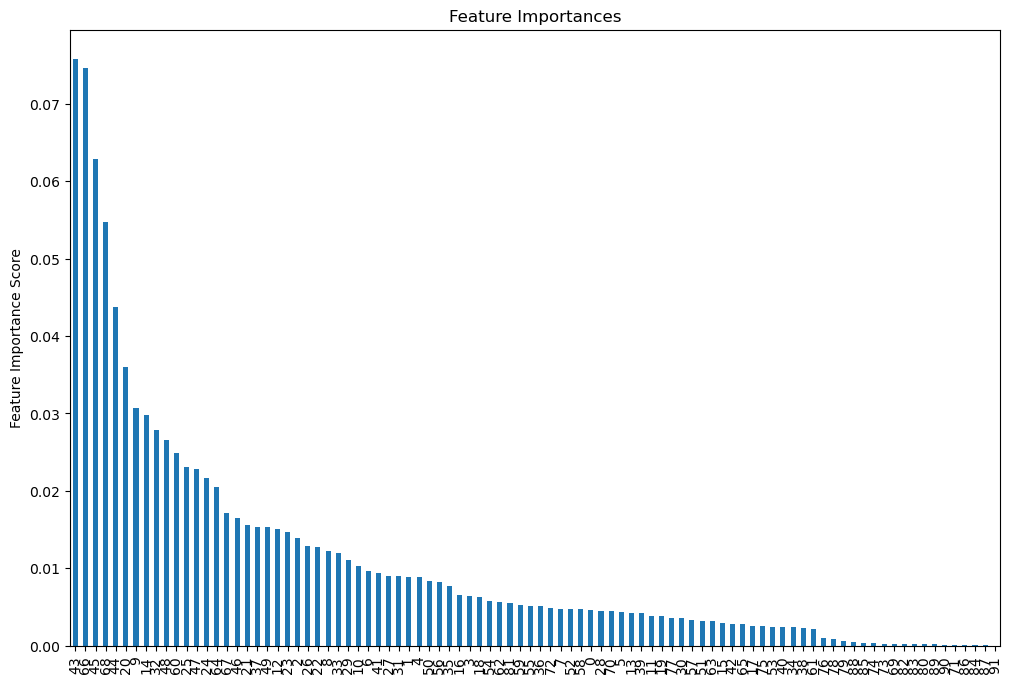

In [7]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

In [8]:
prediction

array([2, 2, 2, ..., 0, 1, 1])

In [9]:
#initializing the model class

func_= Model(train, test)

In [ ]:
#using the make_submission_file method to make predicction and create a submission file

func_.make_submission_file(filename='testing6')

训练过程：

1. 时间上，10分钟左右；
2. CPU占用率为100%；
3. 内存占用率：应该在10G左右；
4. 使用了XGBoost 的GPU，但是看GPU相关监控，GPU占用率为11%,为系统的占用率，没有使用GPU。（基本感觉没有使用GPU）

In [ ]:
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/testing4.csv')
 
a['# lithology'].value_counts()

65000    97125
30000    24010
65030     9027
70000     4754
99000      988
80000      456
90000      401
86000       25
Name: # lithology, dtype: int64

In [10]:
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/testing6.csv')
 
a['# lithology'].value_counts()

65000    94447
30000    24831
65030    10489
70000     5817
80000      610
99000      511
90000       63
86000       16
88000        2
Name: # lithology, dtype: int64